# PyTorch

In [6]:
!pip install pandas

     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     - -------------------------------------- 10.2/341.8 kB ? eta -:--:--
     ---- -------------------------------- 41.0/341.8 kB 653.6 kB/s eta 0:00:01
     ---- -------------------------------- 41.0/341.8 kB 653.6 kB/s eta 0:00:01
     ---- -------------------------------- 41.0/341.8 kB 653.6 kB/s eta 0:00:01
     ------ ------------------------------ 61.4/341.8 kB 363.1 kB/s eta 0:00:01
     ----------- ------------------------ 112.6/341.8 kB 544.7 kB/s eta 0:00:01
     --------------- -------------------- 143.4/341.8 kB 607.9 kB/s eta 0:00:01
     --------------- -------------------- 143.4/341.8 kB 607.9 kB/s eta 0:00:01
     -------------------- --------------- 194.6/341.8 kB 620.6 kB/s eta 0:00:01
     -------------------------- --------- 256.0/341.8 kB 714.4 kB/s eta 0:00:01
     -----------------------------------  337.9/341.8 kB 873.8 kB/s eta 0:00:01
     ------------------------------------ 341.8/341.8

In [3]:
!pip install segmentation_models_pytorch


     ---------------------------------------- 0.0/58.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/58.8 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 58.8/58.8 kB 783.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/68.5 kB ? eta -:--:--
     ---------------------- --------------- 41.0/68.5 kB 960.0 kB/s eta 0:00:01
     ---------------------------------------- 68.5/68.5 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/106.7 kB ? eta -:--:--
   ----------------------- ---------------- 61.4/106.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 106.7/106.7 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   - ----------------------------

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import pandas as pd
size = (256, 256)

import torch

torch.cuda.is_available()

True

In [80]:
df = pd.read_csv("tpsh.csv")
df.image

0     2017-04-10.npy
1     2017-09-12.npy
2     2017-10-07.npy
3     2017-10-22.npy
4     2017-11-16.npy
5     2018-01-15.npy
6     2018-02-09.npy
7     2018-03-11.npy
8     2018-04-25.npy
9     2018-05-10.npy
10    2018-06-24.npy
11    2018-09-17.npy
12    2018-09-27.npy
13    2018-10-02.npy
14    2018-11-01.npy
15    2018-12-01.npy
16    2018-12-26.npy
17    2019-01-05.npy
18    2019-03-01.npy
19    2019-03-26.npy
20    2019-04-15.npy
21    2019-05-10.npy
22    2019-06-19.npy
23    2019-08-03.npy
24    2019-09-02.npy
25    2019-09-27.npy
26    2019-10-12.npy
27    2019-11-21.npy
28    2019-12-16.npy
29    2020-01-05.npy
30    2020-02-19.npy
31    2020-02-24.npy
32    2020-06-13.npy
33    2020-08-12.npy
34    2020-08-22.npy
35    2020-10-16.npy
36    2020-10-26.npy
37    2020-11-05.npy
38    2020-11-30.npy
39    2020-12-20.npy
40    2021-03-10.npy
41    2021-04-04.npy
42    2021-05-24.npy
43    2021-06-08.npy
44    2021-07-28.npy
45    2021-09-01.npy
46    2021-10-06.npy
47    2021-11

In [81]:
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
import cv2
mask = cv2.imread("new_mask.jpg")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask/255
mask = mask.astype("int").astype('float')
mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [82]:
import pandas as pd
import os
import albumentations as A

a = np.load(r'images_np/2017-01-30.npy')
class BuildingsDataset(torch.utils.data.Dataset):

    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            csv_dir,
    ):
        self.csv_dir = csv_dir
        df = pd.read_csv(self.csv_dir)
        self.images = list(df.image)
        self.masks = list(df.masks)
        self.im_dir = images_dir
        self.mask_dir = masks_dir
        self.class_rgb_values = [[0, 0, 0], [255, 255, 255]]

    def __getitem__(self, i):
        # read images and masks
        image = np.load(f"{self.im_dir}/{self.images[i]}")
        mask = np.load(f"{self.mask_dir}/{self.masks[i]}")
        image = np.transpose(image, (1, 2, 0))
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.augmentations.Rotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ])
        transformed = transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        image = np.transpose(image, (2, 0, 1))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = mask.astype("int").astype('float')
        return torch.tensor(image), torch.tensor(mask)

    def __len__(self):
        # return length of
        return len(self.images)

a.shape

(12, 588, 1222)

In [83]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [84]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [85]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x

In [86]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(12, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)

        return output_mask

In [87]:
batch_size = 8
num_epochs = 50
lr = 1e-3
checkpoint_path = "./checkpoint.pth"

In [88]:
# Get train and val dataset instances
masks_dir = "masks_np"
im_dir = "images_np"
csv_tr_dir = "tpsh.csv"
csv_val_dir = "cal.csv"
train_dataset = BuildingsDataset(images_dir=im_dir, masks_dir=masks_dir, csv_dir=csv_tr_dir)

valid_dataset = BuildingsDataset(images_dir=im_dir, masks_dir=masks_dir, csv_dir=csv_val_dir)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [89]:
device = 'cuda'
model = UNet()
model = model.to(device)

In [90]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

In [92]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        #         x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [93]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            #             x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [94]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(50):
    train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    train.append(train_loss)
    valid.append(valid_loss)

    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    data_str = f'Epoch: {epoch + 1:02}\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

  0%|                                                                                                                                                                                                                                                                                               | 0/7 [00:02<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 72 but got size 73 for tensor number 1 in the list.

In [ ]:
(N, H, W) (, W, N)

In [62]:
model = Unet()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

size = (256, 256)

import torch

torch.cuda.is_available()

True

In [61]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

device = 'cuda'

EPOCHS = 45
BATCH_SIZE = 32
LR = 0.001

ratio = 0.5  #Various ratios could perform better for visualization
sample_num = 18

ENCODER = 'resnet50'
WEIGHTS = 'imagenet'


class Unet(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=12,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1, loss2
        return logits

In [6]:
def read_img(path):
    im = Image.open(path)
    img = im.resize((256, 256))
    img = np.array(img)
    img = np.transpose(img, (2, 0, 1))
    img = img / 255.0
    img = torch.tensor(img)
    return img

In [96]:
model = UNet()
model.to(device)
model.eval()

UNet(
  (e1): encoder(
    (conv): conv(
      (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder(
    (conv): conv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, 

(256, 256, 12)


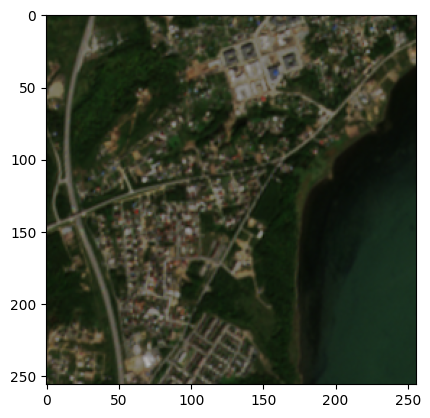

In [211]:
model.load_state_dict(torch.load('./checkpoint.pth'))

image = np.load("images_np/2022-09-21.npy")
image = np.transpose(image, (1, 2, 0))
transform = A.Compose([
            A.RandomCrop(width=256, height=256
                        
                        ),
            ])
transformed = transform(image=image)
image = transformed['image']
im = image
print(im.shape)
image = np.transpose(image, (2, 0, 1))
logits_mask = model(torch.tensor(image).to(device, dtype=torch.float32).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.7) *1.0
pred_mask
plt.imshow(im[:,:,:3])


True

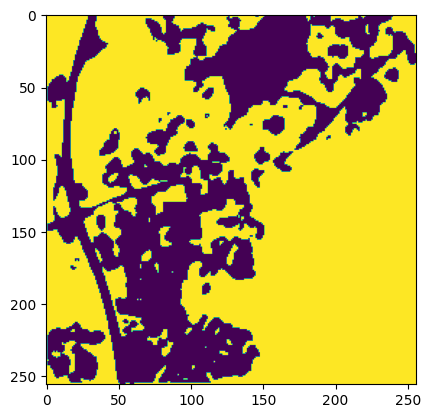

In [212]:
import cv2

plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0)))
new_img = np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0))
new_img = np.array(new_img)
new_img *= 255
new_img = np.concatenate([new_img, new_img, new_img], axis=-1)
cv2.imwrite("1.jpg", new_img)


768 1280


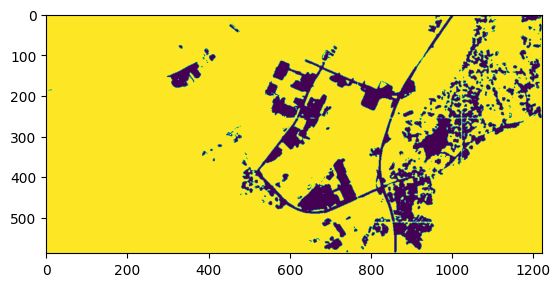

In [297]:
#h w d
import torchvision 
from torchvision.io import read_image 
from torchvision.utils import make_grid 
model.load_state_dict(torch.load('./checkpoint.pth'))
image = np.load("images_np/2022-09-21.npy")
# "images_np/2022-09-21.npy"
a = image.shape[1]
b = image.shape[2]
a1 = a
b1 = b
if a % 256 != 0:
    a = (a//256+1)*256
if b % 256 != 0:
    b = (b//256+1)*256
print(a, b)
image = np.transpose(image, (1, 2, 0))
new = np.zeros((a, b, 12))
new[:image.shape[0], :image.shape[1],:] = image
data = []
for i in range(a//256):
    for j in range(b//256):
        data.append(new[i*256:(i+1)*256, j*256:(j+1)*256, :])
im = image
new_dat = []
for i in range(len(data)):
    image = np.transpose(data[i], (2, 0, 1))
    logits_mask = model(torch.tensor(image).to(device, dtype=torch.float32).unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.7) *1.0
    data[i]=np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0))
    
# k = np.concatenate((*data), axis=1)

fn = 1
for i in range(a//256):
    if i==0:
        k = data[i*(b//256)]
        for j in range(1, b//256):
            k = np.concatenate((k, data[i*(b//256)+j]), axis=1)
        f = k
    else:
        k = data[i*(b//256)]
        for j in range(1, b//256):
            k = np.concatenate((k, data[i*(b//256)+j]), axis=1)
        f = np.concatenate((f, k), axis=0)
f = f[:a1, :b1]
plt.imshow(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


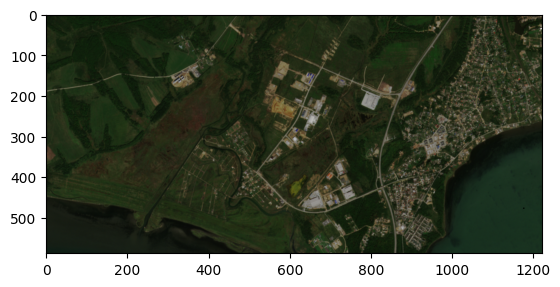

In [298]:
plt.imshow(im[:,:,:3])

In [290]:
import cv2
new_img = f
new_img *= 255
new_img = np.concatenate([new_img, new_img, new_img], axis=-1)
cv2.imwrite("2.jpg", new_img)


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


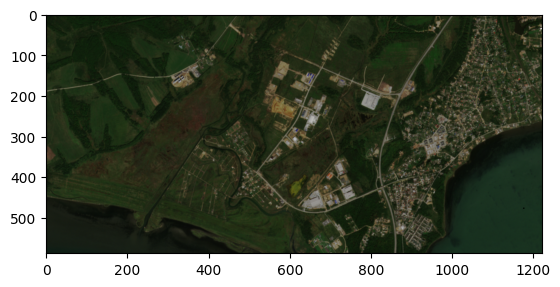

In [268]:
plt.imshow(im[:,:,:3])

In [ ]:
import numpy as np
import cv2 as cv

im = cv.imread('1.jpg')
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
c = max(contours, key=cv2.contourArea)
img = np.zeros((256, 256, 3), np.uint8)
# cv.drawContours(im, c, -1, (0, 255, 0), 2)
final = cv2.fillPoly(img, pts=[c], color=(255, 255, 255))
cv.imwrite("1.jpg", final)
plt.imshow(final)

In [ ]:
mask = cv.imread('1.jpg')
img_old = Image.open('1111.jpg').convert('L').resize((256, 256))
img_old = np.array(img_old)
img_old = np.expand_dims(img_old, axis=-1)

image = np.concatenate([img_old, img_old, img_old], axis=-1)
plt.imshow(image)
cutted = cv2.bitwise_and(image, mask)
plt.imshow(cutted)
plt.imsave('gray.jpg', cutted)

In [102]:
def colors_blue(a, maxx, minn):
    if 0 < a <= 32:
        k = (0, 0, 16)
    elif 32 < a <= 64:
        k = (0, 0, 48)
    elif 64 < a <= 96:
        k = (0, 0, 80)
    elif 96 < a <= 128:
        k = (0, 0, 112)
    elif 128 < a <= 160:
        k = (0, 0, 144)
    elif 160 < a <= 192:
        k = (0, 0, 176)
    elif 192 < a <= 224:
        k = (0, 0, 208)
    elif 224 < a <= 255:
        k = (0, 0, 240)
    else:
        k = (0, 0, 0)
    f = 2
    k = (k[0], k[1], k[2] * f if k[2] * f <= 255 else 255)

    return k

In [103]:

def colors_all(a, maxx, minn):
    am = (maxx - minn) // 11
    if a == 0:
        return (0, 0, 0)
    data = [(254, 240, 1),
            (255, 206, 3),
            (253, 154, 1),
            (253, 97, 4),
            (255, 44, 5),
            (240, 5, 5),
            (204, 0, 51),
            (153, 0, 102),
            (102, 0, 153),
            (51, 0, 204),
            (0, 0, 100),
            (0, 0, 50)]
    num = 11 - (a - minn) // am
    return data[num]

# yellow red blue



In [ ]:
final = plt.imread("gray.jpg")
mask = cv.imread('1.jpg')
img = np.zeros((256, 256, 3), np.uint8)
maxx = 0
minn = 255
m = 255
for i in range(len(final)):
    for j in range(len(final[i])):
        if final[i][j][0] > maxx:
            maxx = final[i][j][0]
        if 0 < final[i][j][0] < minn:
            minn = final[i][j][0]
        if 0 < final[i][j][0] < m:
            if mask[i][j][0] == 255:
                m = final[i][j][0]
for i in range(len(final)):
    for j in range(len(final[i])):
        img[i][j] = colors_all(final[i][j][0], maxx, minn)
plt.imshow(img)
print(img.shape)
img_map = np.array(img)
plt.imsave('lake.png', img_map)
print(m)

In [ ]:
data = [(254, 240, 1),
        (255, 206, 3),
        (253, 154, 1),
        (253, 97, 4),
        (255, 44, 5),
        (240, 5, 5),
        (204, 0, 51),
        (153, 0, 102),
        (102, 0, 153),
        (51, 0, 204),
        (0, 0, 100),
        (0, 0, 50)]
gray_depth = {
    (16, 256): 1.5,
    (12, 15): 3,
    (9, 11): 6,
    (7, 8): 10,
    (4, 6): 20,
    (1, 3): 65,
}


def make(color):
    img = np.zeros((21, 40, 3), np.uint8)
    for i in range(21):
        for j in range(40):
            img[i][j] = color
    return img

In [ ]:
beg = make((254, 240, 1))
d = 0
for i in gray_depth:
    if i[0] <= m < i[1]:
        d = gray_depth[i]
print(beg.shape)
for i in data[1:]:
    beg = np.vstack((beg, make(i)))
plt.imshow(beg)
plt.imsave("grad.png", beg)
img = beg
for i in range(12):
    if i > 7:
        if i == 11:
            cv2.putText(img, f">{i * d}", (3, 13 + i * 21), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1)
        else:
            cv2.putText(img, f"{i * d}", (3, 13 + i * 21), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1)
    else:
        cv2.putText(img, f"{i * d}", (3, 13 + i * 21), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1)
im = np.zeros((4, 40, 3), np.uint8)
img = np.vstack((img, im))
plt.imsave("grad.png", img)
map = plt.imread('lake.png')
map = np.array(map)
new_m_3 = np.zeros((256, 256, 3))
for i in range(256):
    for j in range(256):
        new_m_3[i][j] = (new_m_3[i][j][:3])
print(new_m_3.shape)
# plt.imshow(img_map)
f = np.concatenate((img_map, img), axis=1)
plt.imshow(f)
plt.imsave("output.png", f)